In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

#데이터 불러오기
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()

#기본 흑백이미지 행렬을 1차원 행렬로 바꿔주고, 0~1사이값으로 전처리 하기.
train_scaled = train_input.reshape(-1,28,28,1)/255.0

#훈련데이터 검증데이터 나누기.
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [2]:
#1차원으로 바뀐 형태.
print(train_input.shape)
print(train_scaled.shape)

(60000, 28, 28)
(48000, 28, 28, 1)


## 합성곱 신경망 만들기
- 합성곱 layer에서 이미지의 특징을 검출한 후 Dense layer에서 클래스에 따른 분류 확률을 계산한다.

In [3]:
#Sequential 클래스 객체를 만들고 합성곱 layer(Conv2D) 추가.
#합성곱 층은 32개의 필터를 사용하고, 커널의 크기는 3x3, 활성화함수는 relu, 세임패딩을 사용한다.
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

In [4]:
#풀링 층 추가하기.
#maxpooling 2x2
#input의 가로 세로의 크기가 같으면 정수 한개로 크기를 지정할 수 있다.
model.add(keras.layers.MaxPooling2D(2))

In [5]:
#두번째 합성곱층 , 풀링층 추가.
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

## Dense layer로 입력.
- 합성곱, 풀링층이 끝나면 Dense layer로 가기위해 다차원 feature map을 일렬로 펼쳐야 한다.

In [6]:
#Dense layer에서 Flatten클래스를 사용
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10,activation='softmax'))

## Model 구조 파악.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [8]:
#층을 그림으로 표현하기.
import pydot

import graphviz

from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot

keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## 모델 훈련, 평가.

In [9]:
#Adam 옵티마이저 사용, MoedlCheckpoint 콜백, EarlyStopping 콜백 사용.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

#콜백
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

#모델 훈련
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.7326 - accuracy: 0.7303 - val_loss: 0.3486 - val_accuracy: 0.8699
Epoch 2/20
1500/1500 [==============================] - 31s 21ms/step - loss: 0.3631 - accuracy: 0.8711 - val_loss: 0.2815 - val_accuracy: 0.8938
Epoch 3/20
1500/1500 [==============================] - 36s 24ms/step - loss: 0.3080 - accuracy: 0.8879 - val_loss: 0.2565 - val_accuracy: 0.9047
Epoch 4/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.2629 - accuracy: 0.9030 - val_loss: 0.2430 - val_accuracy: 0.9094
Epoch 5/20
1500/1500 [==============================] - 36s 24ms/step - loss: 0.2415 - accuracy: 0.9129 - val_loss: 0.2275 - val_accuracy: 0.9173
Epoch 6/20
1500/1500 [==============================] - 35s 24ms/step - loss: 0.2142 - accuracy: 0.9227 - val_loss: 0.2189 - val_accuracy: 0.9193
Epoch 7/20
1500/1500 [==============================] - 36s 24ms/step - loss: 0.1966 - accuracy: 0.9285 - val_loss: 0.2394 -

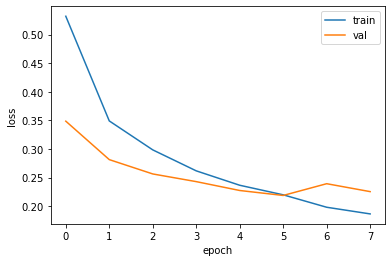

In [12]:
# 6번째 이후로 train set에 의한 loss가 감소하고 val set에 의한 loss가 정체되고 있으므로 6번째가 최적의 epoch이다.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [13]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 4ms/step - loss: 0.2189 - accuracy: 0.9193


[0.2188921570777893, 0.9192500114440918]

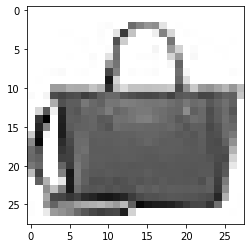

In [17]:
#흑백 이미지를 예측하기위해서 (28,28,1) 배열을 (28,28)로 바꿔주어야 한다.
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [18]:
#예측확률 결과를 보면 9번째가 거의 1에 가깝다.
preds = model.predict(val_scaled[0:1])
print(preds)

[[9.4900427e-17 3.0171253e-24 3.4752336e-17 5.5559922e-17 7.2960062e-16
  5.0504753e-18 7.0151193e-13 2.2748899e-19 1.0000000e+00 2.4528008e-18]]


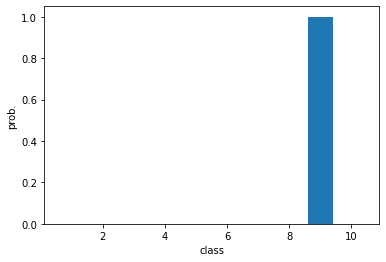

In [19]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [20]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵글부츠']

In [ ]:
#preds배열에서 가장 큰 인덱스를 찾아 classes리스트의 인덱스로 사용한다.
import numpy as np
print(classes[np.argmax(preds)])

### test_set으로 평가하기
- test set은 모델을 출시하기 직전 딱 한번만 사용해야 한다.

In [22]:
test_scaled = test_input.reshape(-1,28,28,1)/255.0

In [23]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 4ms/step - loss: 0.2474 - accuracy: 0.9099


[0.2473660111427307, 0.9099000096321106]